In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from datetime import datetime

def plot_alarm_heatmap(
    csv_filename,
    lowest_percentage,
    highest_percentage,
    step_percent,
    debug,
    detector_interval,   # e.g., 30 for ±30%
    atm_interval         # e.g., 10 for ±10%
):
    # Define colors for each case
    COLOR_LIGHT_GREEN = (0.0, 1.0, 0.0)
    COLOR_LIGHT_ORANGE = (1.0, 0.85, 0.5)
    COLOR_DARK_ORANGE = (1.0, 0.55, 0.0)
    COLOR_RED = (1.0, 0.2, 0.2)
    COLOR_DARK_GREEN = (0.0, 0.3, 0.0)
    COLOR_DARKER_GREEN = (0.0, 0.15, 0.0)

    # Read the CSV file
    df = pd.read_csv(csv_filename)

    # Create a pivot table for the heatmap with swapped axes
    pivot_data = df.pivot_table(
        index='gbf_T(s)',      # y-axis
        columns='clk_s_T(s)',  # x-axis
        values='Alarm_Detector',   # placeholder
        aggfunc='first'
    )

    # Create a color matrix
    color_matrix = np.zeros((len(pivot_data.index), len(pivot_data.columns), 3))

    # Prepare value lists for interval checks
    x_values = list(pivot_data.columns)
    y_values = list(pivot_data.index)

    if debug:
        print(-lowest_percentage - detector_interval)
        print(-lowest_percentage - atm_interval)
        print(highest_percentage - detector_interval)
        print(highest_percentage - atm_interval)

    for i, gbf_T in enumerate(y_values):      # y-axis
        for j, clk_T in enumerate(x_values):  # x-axis
            # Find the matching row
            match = df[(df['clk_s_T(s)'] == clk_T) & (df['gbf_T(s)'] == gbf_T)]
            if match.empty:
                # Fill with black if missing
                color_matrix[i, j] = [0, 0, 0]
                continue
            row = match.iloc[0]

            detector_alarm = int(str(row['Alarm_Detector']).strip("'"))
            atm_alarm = int(str(row['Alarm_ATM']).strip("'"))

            if debug:
                print(i)
                print(j)
                print(i*step_percent)
                print(j*step_percent)

            # Index-based rectangle check
            gbf = lowest_percentage + i * step_percent
            clk = lowest_percentage + j * step_percent
            if (-detector_interval <= clk <= detector_interval) and (-atm_interval <= gbf <= atm_interval):
                in_expected = True
            else:
                in_expected = False

            # Color logic (simple and direct)
            if in_expected:
                if detector_alarm == 0 and atm_alarm == 0:
                    color_matrix[i, j] = COLOR_LIGHT_GREEN
                elif detector_alarm == 0 and atm_alarm == 1:
                    color_matrix[i, j] = COLOR_LIGHT_ORANGE
                elif detector_alarm == 1 and atm_alarm == 1:
                    color_matrix[i, j] = COLOR_DARK_ORANGE
                else:
                    color_matrix[i, j] = [0, 0, 0]  # fallback (should not occur)
            else:
                if detector_alarm == 0 and atm_alarm == 0:
                    color_matrix[i, j] = COLOR_RED
                elif detector_alarm == 0 and atm_alarm == 1:
                    color_matrix[i, j] = COLOR_DARK_GREEN
                elif detector_alarm == 1 and atm_alarm == 1:
                    color_matrix[i, j] = COLOR_DARKER_GREEN
                else:
                    color_matrix[i, j] = [0, 0, 0]  # fallback (should not occur)

    # Create the plot
    plt.figure(figsize=(12, 8))

    # Create custom x and y labels for percentages, matching the number of columns/rows
    x_labels = [f"{lowest_percentage + j * step_percent}%" for j in range(len(x_values))]
    y_labels = [f"{lowest_percentage + i * step_percent}%" for i in range(len(y_values))]

    # Plot the heatmap
    plt.imshow(color_matrix[::-1], aspect='auto') # Invert y-axis because imshow() plots the first row on the top left
    plt.xticks(range(len(x_labels)), x_labels, rotation=45)
    plt.yticks(range(len(y_labels)), y_labels[::-1])  # Reverse y-labels to match the plot

    # Add labels and title
    plt.xlabel('Clock Period Change')
    plt.ylabel('GBF Period Change')
    plt.title('Alarm States Heatmap')

    # Add a legend with new color meanings
    legend_elements = [
        Patch(color=COLOR_LIGHT_GREEN, label='No Alarms (in expected)'),
        Patch(color=COLOR_LIGHT_ORANGE, label='Only ATM Alarm (in expected)'),
        Patch(color=COLOR_DARK_ORANGE, label='Both Alarms (in expected)'),
        Patch(color=COLOR_RED, label='No Alarms (out of expected)'),
        Patch(color=COLOR_DARK_GREEN, label='Only ATM Alarm (out of expected)'),
        Patch(color=COLOR_DARKER_GREEN, label='Both Alarms (out of expected)')
    ]
    plt.legend(handles=legend_elements, loc='upper left')

    plt.tight_layout()

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = f"Heatmaps/heatmap_{timestamp}.png"
    plt.savefig(save_path)
    print(f"Heatmap saved to {save_path}")
    
    plt.show()

Heatmap saved to Heatmaps/heatmap_20250523_132336.png


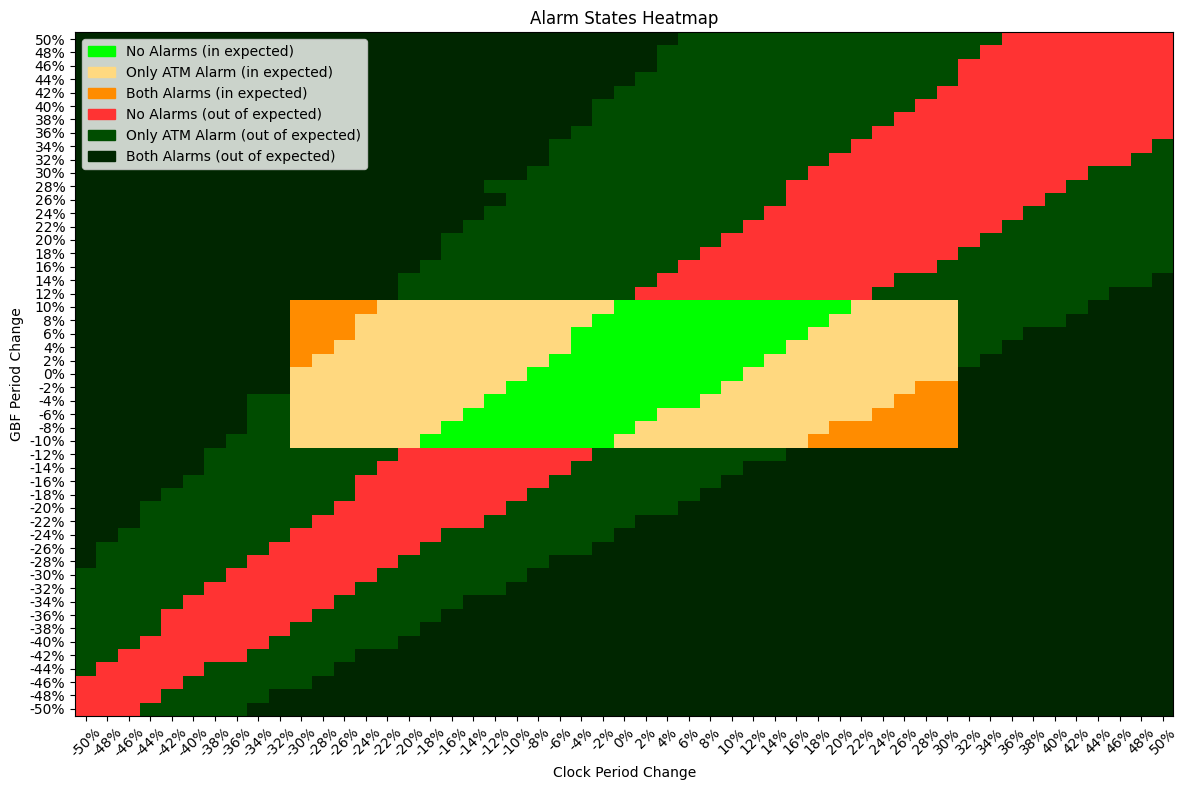

In [15]:
# Plotting the alarm heatmap using frequencies changes instead of periods changes. 
# Latest version, and the one which seems to have the best results.

plot_alarm_heatmap("Simulations_Results/simulation_results_50_2percent_v9.csv", -50, 50, 2, False, 30, 10)

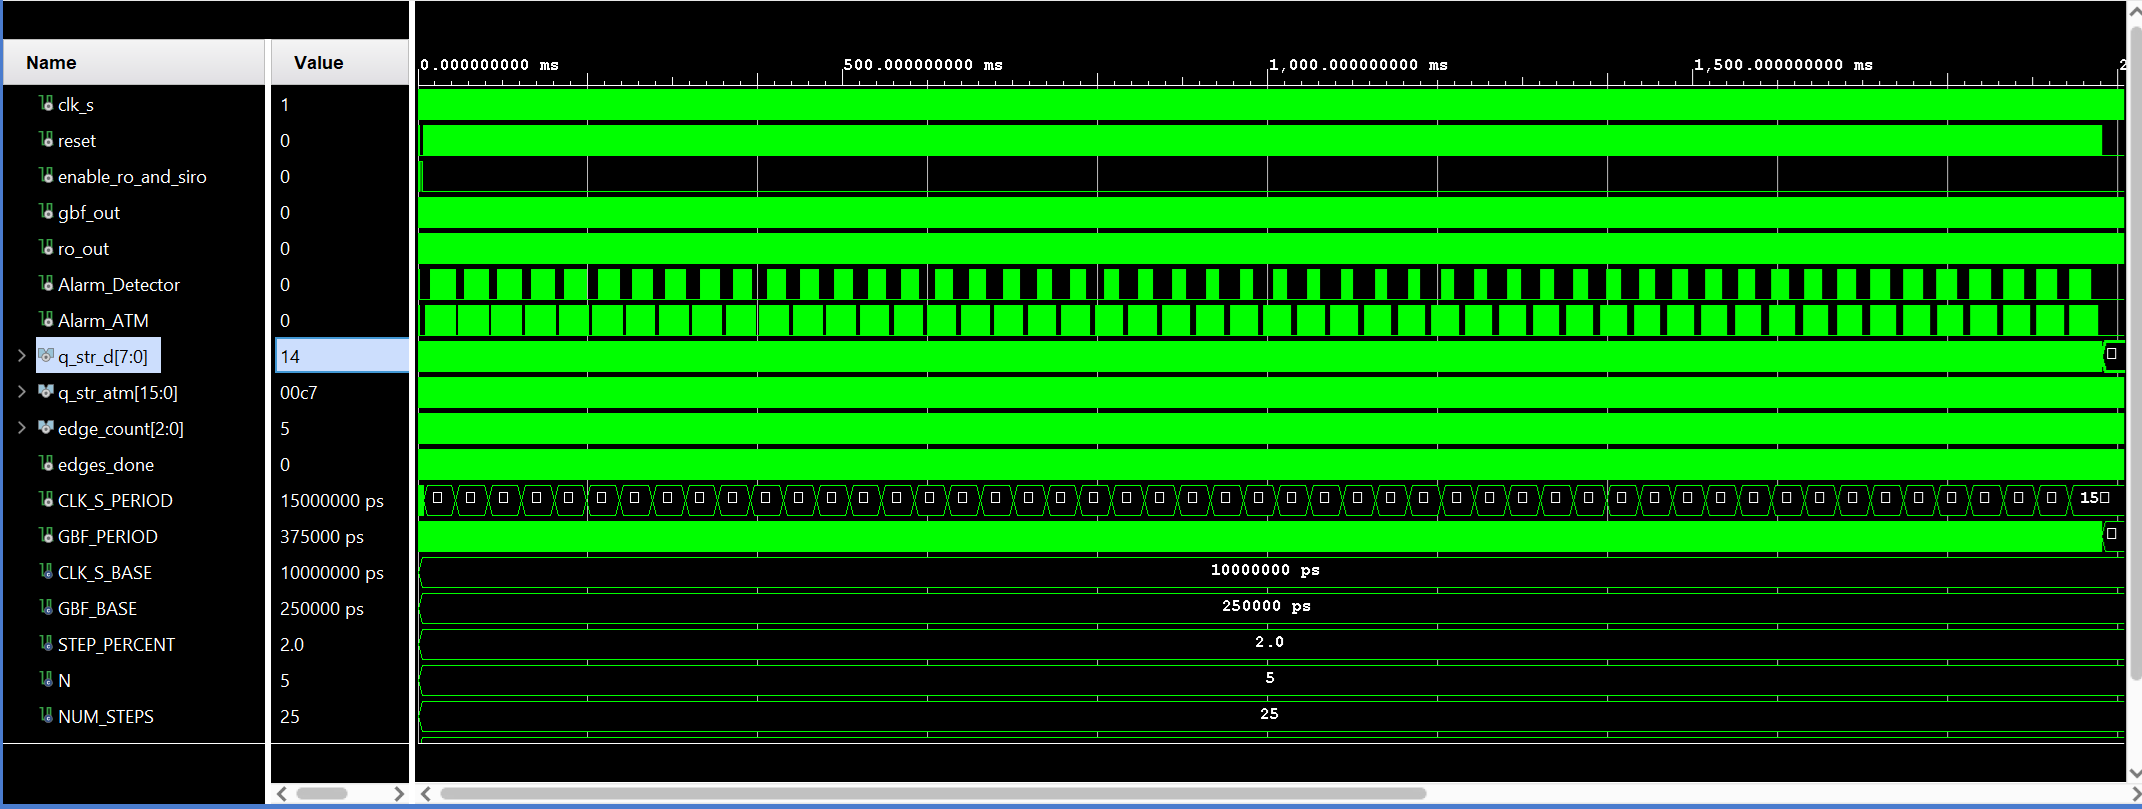

In [16]:
from IPython.display import Image, display

display(Image(filename="MdR_Latest_Simulation_Results.png"))

# Latest simulations results, used in the heatmap plot above.